# Entries

1. Historical statistics of direct confrontation (team 1 vs team 2)
2. Statistics of *N* previous matches for each team
3. Home player or away player
4. Current points on championship
5. Match day matters?

In [3]:
import sys
sys.path.append("..")

In [4]:
from pprint import pprint
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from db.database import DAO

In [5]:
dao = DAO()
matches_collection = dao.matches()

In [6]:
# Sample match for testing
sample = matches_collection.find_one()
pprint(sample)

{'_id': ObjectId('5ac952926b5b9e2af46c59ef'),
 'arbiter': 'Leonardo Gaciba da Silva',
 'away_team': 'Santos',
 'cards': [{'player': 'Alex Sandro', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Zé Eduardo', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Herrera', 'team': 'BOT', 'type': 'yellow'},
           {'player': 'Wesley', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Alex Sandro', 'team': 'SAN', 'type': 'red'}],
 'coaches': {'away_team': 'Dorival Júnior', 'home_team': 'Joel Santana'},
 'home_team': 'Botafogo',
 'location': {'city': 'Brasil, Rio de Janeiro, RJ', 'stadium': 'Engenhão'},
 'players': {'away_team': [{'name': 'Felipe Garcia', 'position': 'GOL'},
                           {'name': 'Bruno Aguiar', 'position': 'ZAD'},
                           {'name': 'Durval', 'position': 'ZAE'},
                           {'name': 'Maranhão', 'position': 'LAD'},
                           {'name': 'Alex Sandro', 'position': 'LAE'},
                     

## Match Vectorizer
Takes a match in the above format and extracts the most important characteristics in the following order:

<ol>
- Current match statistics
<li> Home team score </li>
<li> Away team score </li>

- Statistics of all confronts of the teams
<li> Goals by home team </li>
<li> Goals by away team </li>
<li> Number of victories of home team </li>
<li> Number o victories of away team </li>
<li> Number of draws </li>

- Statistics of N previous games of each team
<li> Balance of N last games of home team </li>
<li> Balance of N last games of away team </li>
</ol>

In [7]:
# Default match feature extractor. ht is home_team and at is away_team
N = 4
labels = ['ht_score', 'at_score', 'goals_ht', 'goals_at', 'wins_ht', 'wins_at', 'draws', 
          *(['sg_ht']*N), *(['sg_at']*N)]
def vectorize_match(dao, match, N):
    stats = match['statistics']
    score = match['score']
    home_team_last_sg = dao.get_last_N_balances(match['home_team'], N)
    away_team_last_sg = dao.get_last_N_balances(match['away_team'], N)
    return [
            score['home_team'],
            score['away_team'], 
            stats['goals_home_team'], 
            stats['goals_away_team'],
            stats['wins_home_team'], 
            stats['wins_away_team'], 
            stats['previous_draws'], 
            *home_team_last_sg, 
            *away_team_last_sg
           ]

In [122]:
# Vectorize matches from 2016
matches = matches_collection.find({'year':2017})
data = [vectorize_match(dao, match, N) for match in matches]
data = pd.DataFrame(data=data, columns=labels)
data.head()

,ht_score,at_score,goals_ht,goals_at,wins_ht,wins_at,draws,sg_ht,sg_ht,sg_ht,sg_ht,sg_at,sg_at,sg_at,sg_at
0,1,1,78,91,23,24,16,-1,0,2,-2,2,-2,0,0
1,1,1,10,4,4,0,3,0,0,1,-2,0,1,1,-1
2,3,2,85,82,26,21,10,-1,-1,-2,0,1,1,-2,2
3,1,0,55,88,12,32,15,0,1,1,1,1,0,1,0
4,4,0,81,48,25,12,15,-1,1,1,0,0,0,-1,1


In [123]:
# Splitting X and Y
Y = data.iloc[:,:2]
X = data.iloc[:,2:]
Y.head() # Y.values to extract the matrix from dataframe

,ht_score,at_score
0,1,1
1,1,1
2,3,2
3,1,0
4,4,0


In [124]:
# Feature Scaling
from sklearn.preprocessing import RobustScaler
xscaler = RobustScaler()
yscaler = RobustScaler()
X = xscaler.fit_transform(X)
Y = yscaler.fit_transform(Y)

### Splitting training and test sets
- Training set size: 80%
- Testing set size: 20%
- Temporal order maintained (random_state=0)

In [114]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Building the Perceptron ANN
- Input layer size: 13 (see match vectorizer for description)
- Output layer size: 2

### Task 1: Train/Test

In [115]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense

In [127]:
metrics = ['mean_absolute_error', 'binary_accuracy']
log = {}
log_val = {}

In [144]:
# Creating the neural network
loss = 'mse'
opt = 'adam'
init = 'glorot_uniform'
num_hidden = 32
model = Sequential()
model.add(Dense(num_hidden, input_dim=len(X_train[0]), activation='tanh', kernel_initializer=init))
model.add(Dense(2, activation='linear', kernel_initializer=init))

model.compile(loss=loss, optimizer=opt, metrics=metrics)

In [145]:
# # Creating the neural network - BEST MODEL
# metrics = ['mean_absolute_error', 'binary_accuracy']
# model = Sequential()
# model.add(Dense(8, input_dim=len(X_train[0]), activation='tanh'))
# model.add(Dense(2, activation='linear'))

# # model.compile(loss='mse', optimizer='adam', metrics=metrics)

### Statistics for different activation functions
With MSE loss and SGD optimizer


Activation| MAE | Binary accuracy
--- | --- | ---
linear + linear| 65.65 | **46.05**
relu + linear | 76.02 | 46.05
linear + relu | problema min=1|
linear + sigmoid | 66.79 | 40.13
sigmoid | 67.77 | 40.13
sigmoid + relu | 71.32 | 36.18
sigmoid + linear | 67.90 | 42.11
linear + tanh | |
relu + tanh | |

In [146]:
# Training
validation = False
if validation:
    history = model.fit(X_train, Y_train, epochs=300, batch_size=10, verbose=1, validation_split=0.1)
else:
    history = model.fit(X_train, Y_train, epochs=300, batch_size=10, verbose=1)

scores = model.evaluate(X_test, Y_test, verbose=0)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

Epoch 1/300
303/303 [==============================] - 0s 2ms/step - loss: 1.3646 - mean_absolute_error: 0.8839 - binary_accuracy: 0.2624
Epoch 2/300
303/303 [==============================] - 0s 229us/step - loss: 1.0664 - mean_absolute_error: 0.7805 - binary_accuracy: 0.2921
Epoch 3/300
303/303 [==============================] - 0s 238us/step - loss: 0.9663 - mean_absolute_error: 0.7512 - binary_accuracy: 0.3201
Epoch 4/300
303/303 [==============================] - 0s 215us/step - loss: 0.9272 - mean_absolute_error: 0.7418 - binary_accuracy: 0.3069
Epoch 5/300
303/303 [==============================] - 0s 276us/step - loss: 0.9060 - mean_absolute_error: 0.7366 - binary_accuracy: 0.3069
Epoch 6/300
303/303 [==============================] - 0s 255us/step - loss: 0.8917 - mean_absolute_error: 0.7294 - binary_accuracy: 0.3168
Epoch 7/300
303/303 [==============================] - 0s 234us/step - loss: 0.8815 - mean_absolute_error: 0.7253 - binary_accuracy: 0.3251
Epoch 8/300
303/303 [=

303/303 [==============================] - 0s 233us/step - loss: 0.7971 - mean_absolute_error: 0.6877 - binary_accuracy: 0.3416
Epoch 60/300
303/303 [==============================] - 0s 245us/step - loss: 0.7965 - mean_absolute_error: 0.6885 - binary_accuracy: 0.3317
Epoch 61/300
303/303 [==============================] - 0s 239us/step - loss: 0.7948 - mean_absolute_error: 0.6892 - binary_accuracy: 0.3300
Epoch 62/300
303/303 [==============================] - 0s 229us/step - loss: 0.7916 - mean_absolute_error: 0.6867 - binary_accuracy: 0.3317
Epoch 63/300
303/303 [==============================] - 0s 250us/step - loss: 0.7910 - mean_absolute_error: 0.6827 - binary_accuracy: 0.3300
Epoch 64/300
303/303 [==============================] - 0s 330us/step - loss: 0.7893 - mean_absolute_error: 0.6861 - binary_accuracy: 0.3317
Epoch 65/300
303/303 [==============================] - 0s 338us/step - loss: 0.7903 - mean_absolute_error: 0.6857 - binary_accuracy: 0.3251
Epoch 66/300
303/303 [====

303/303 [==============================] - 0s 242us/step - loss: 0.7236 - mean_absolute_error: 0.6562 - binary_accuracy: 0.3333
Epoch 118/300
303/303 [==============================] - 0s 238us/step - loss: 0.7249 - mean_absolute_error: 0.6539 - binary_accuracy: 0.3251
Epoch 119/300
303/303 [==============================] - 0s 305us/step - loss: 0.7228 - mean_absolute_error: 0.6573 - binary_accuracy: 0.3284
Epoch 120/300
303/303 [==============================] - 0s 312us/step - loss: 0.7203 - mean_absolute_error: 0.6561 - binary_accuracy: 0.3300
Epoch 121/300
303/303 [==============================] - 0s 248us/step - loss: 0.7196 - mean_absolute_error: 0.6522 - binary_accuracy: 0.3284
Epoch 122/300
303/303 [==============================] - 0s 228us/step - loss: 0.7192 - mean_absolute_error: 0.6526 - binary_accuracy: 0.3350
Epoch 123/300
303/303 [==============================] - 0s 247us/step - loss: 0.7162 - mean_absolute_error: 0.6528 - binary_accuracy: 0.3333
Epoch 124/300
303/30

303/303 [==============================] - 0s 233us/step - loss: 0.6518 - mean_absolute_error: 0.6182 - binary_accuracy: 0.3383
Epoch 175/300
303/303 [==============================] - 0s 255us/step - loss: 0.6508 - mean_absolute_error: 0.6183 - binary_accuracy: 0.3383
Epoch 176/300
303/303 [==============================] - 0s 268us/step - loss: 0.6552 - mean_absolute_error: 0.6188 - binary_accuracy: 0.3350
Epoch 177/300
303/303 [==============================] - 0s 258us/step - loss: 0.6501 - mean_absolute_error: 0.6200 - binary_accuracy: 0.3366
Epoch 178/300
303/303 [==============================] - 0s 284us/step - loss: 0.6506 - mean_absolute_error: 0.6185 - binary_accuracy: 0.3317
Epoch 179/300
303/303 [==============================] - 0s 256us/step - loss: 0.6486 - mean_absolute_error: 0.6170 - binary_accuracy: 0.3251
Epoch 180/300
303/303 [==============================] - 0s 255us/step - loss: 0.6454 - mean_absolute_error: 0.6169 - binary_accuracy: 0.3416
Epoch 181/300
303/30

303/303 [==============================] - 0s 212us/step - loss: 0.5841 - mean_absolute_error: 0.5836 - binary_accuracy: 0.3515
Epoch 232/300
303/303 [==============================] - 0s 253us/step - loss: 0.5809 - mean_absolute_error: 0.5841 - binary_accuracy: 0.3416
Epoch 233/300
303/303 [==============================] - 0s 252us/step - loss: 0.5826 - mean_absolute_error: 0.5851 - binary_accuracy: 0.3515
Epoch 234/300
303/303 [==============================] - 0s 280us/step - loss: 0.5812 - mean_absolute_error: 0.5836 - binary_accuracy: 0.3498
Epoch 235/300
303/303 [==============================] - 0s 268us/step - loss: 0.5787 - mean_absolute_error: 0.5835 - binary_accuracy: 0.3482
Epoch 236/300
303/303 [==============================] - 0s 258us/step - loss: 0.5797 - mean_absolute_error: 0.5846 - binary_accuracy: 0.3498
Epoch 237/300
303/303 [==============================] - 0s 248us/step - loss: 0.5777 - mean_absolute_error: 0.5829 - binary_accuracy: 0.3482
Epoch 238/300
303/30

303/303 [==============================] - 0s 238us/step - loss: 0.5279 - mean_absolute_error: 0.5560 - binary_accuracy: 0.3597
Epoch 289/300
303/303 [==============================] - 0s 237us/step - loss: 0.5229 - mean_absolute_error: 0.5553 - binary_accuracy: 0.3647
Epoch 290/300
303/303 [==============================] - 0s 252us/step - loss: 0.5231 - mean_absolute_error: 0.5571 - binary_accuracy: 0.3515
Epoch 291/300
303/303 [==============================] - 0s 261us/step - loss: 0.5260 - mean_absolute_error: 0.5605 - binary_accuracy: 0.3614
Epoch 292/300
303/303 [==============================] - 0s 258us/step - loss: 0.5212 - mean_absolute_error: 0.5561 - binary_accuracy: 0.3663
Epoch 293/300
303/303 [==============================] - 0s 255us/step - loss: 0.5193 - mean_absolute_error: 0.5532 - binary_accuracy: 0.3647
Epoch 294/300
303/303 [==============================] - 0s 297us/step - loss: 0.5203 - mean_absolute_error: 0.5562 - binary_accuracy: 0.3597
Epoch 295/300
303/30

In [147]:
varying_item = num_hidden
for metric in metrics:
    x = log.get(varying_item, [])
    x.append(history.history[metric])
    log[varying_item] = x
    
    if validation:
        x = log_val.get(varying_item, [])
        x.append(history.history['val_'+metric])
        log_val[varying_item] = x
len(log)

5

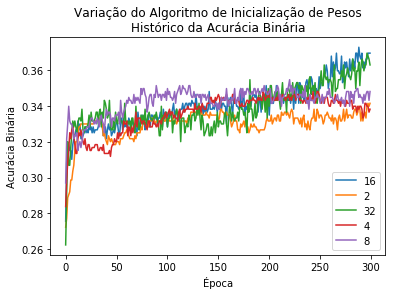

In [148]:
save = True
data_val = {str(k).upper() + ' (Validação)':log_val[k][1] for k in log_val}
data_ba = {str(k).upper():log[k][1] for k in log}

data = pd.DataFrame({**data_val, **data_ba})

data.plot()
plt.xlabel('Época')
plt.ylabel('Acurácia Binária')
plt.title('Variação de Neurônios na Camada Escondida\nHistórico da Acurácia Binária')

if save: plt.savefig('../plots/{}_acuracia_binaria.eps'.format(varying_item), format='eps')

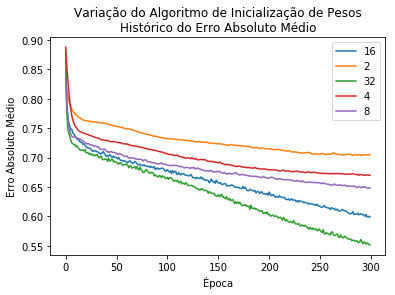

In [149]:
save = True
data_mae = {str(k).upper() + ' (Validação)':log_val[k][0] for k in log_val}
data_ba = {str(k).upper():log[k][0] for k in log}

data = pd.DataFrame({**data_mae, **data_ba})
data.plot()
plt.xlabel('Época')
plt.ylabel('Erro Absoluto Médio')
plt.title('Variação do Algoritmo de Inicialização de Pesos\nHistórico do Erro Absoluto Médio')
#plt.yscale('log')
if save: plt.savefig('../plots/{}_erro_absoluto_medio.eps'.format(varying_item), format='eps')

In [125]:
evaluation = model.evaluate(X, Y, verbose=1)
print('Mean absolute error: {}\nBinary accurracy: {}'.format(evaluation[1], evaluation[2]))
k = model.predict(X_test)
yscaler.inverse_transform(k)

260/260 [==============================] - 0s 64us/step
Mean absolute error: 0.5043825828112088
Binary accurracy: 0.275


array([[1.8946598 , 0.7764601 ],
       [2.8153713 , 0.21430439],
       [1.9685993 , 1.1432283 ],
       [2.8079038 , 0.4893294 ],
       [2.443507  , 0.69368666],
       [1.837235  , 0.7200189 ],
       [1.8291259 , 0.82531923],
       [2.909269  , 0.43842775],
       [3.1421924 , 0.4333188 ],
       [1.4117274 , 1.3275082 ],
       [2.3635478 , 0.5108967 ],
       [1.7655888 , 1.0181252 ],
       [1.849521  , 1.0511179 ],
       [3.0537999 , 0.20320421],
       [1.8089936 , 1.21081   ],
       [1.3581839 , 1.1073215 ],
       [2.3552241 , 1.0690911 ],
       [1.6765771 , 0.9789779 ],
       [1.9225311 , 1.0895269 ],
       [1.528841  , 1.1490186 ],
       [1.8048294 , 1.2321199 ],
       [2.3713946 , 0.7282874 ],
       [1.2751544 , 1.200211  ],
       [2.189666  , 0.88924515],
       [2.9692795 , 0.2269541 ],
       [1.8265939 , 0.4381578 ],
       [1.8716974 , 1.2244227 ],
       [1.7351781 , 0.74284816],
       [1.5269682 , 0.88777083],
       [2.0081627 , 1.05813   ],
       [1.

In [126]:
len(X)

260

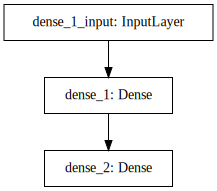

In [20]:
# Network architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))